# The Volz NE Model (2007)

This notebook will show an implementation of the Volz Neighbour Exchange SIR model. I will explain each step of the ordinary differential equations as well as explaion the probability generating functions. 

This model assumes that each individuals number of current contacts stays the same but that the identity of the contacts change over time, they change at a steady rate $\rho$.

In [5]:
import scipy as sp
import scipy.integrate as sp_int
import matplotlib.pyplot as plt
import math
import numpy as np
import networkx as nx

Below I have coded an example of the nodes in a network having neighbour exchange occuring from timestemp 0 to timestep 1

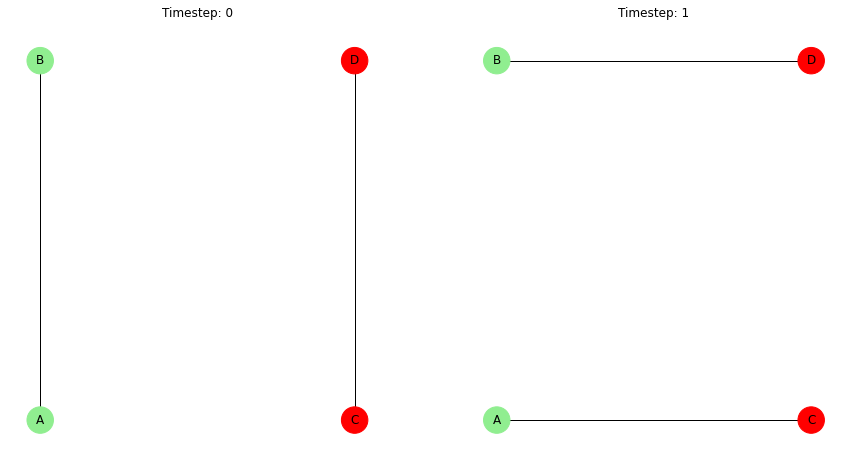

In [40]:
fig, ax = plt.subplots(ncols = 2, figsize = (15,8))
nx.draw(nx.from_edgelist([['A','B'],
                 ['C','D']]), pos = {'A':(0.1, 0.1),
                                    'B':(0.1, 0.2),
                                    'C':(0.2,0.1),
                                    'D':(0.2,0.2)},
       node_size = 700,
       node_color = {'A': "lightgreen", 'B': "lightgreen", 'C': "red", 'D': "red"}.values(),
       with_labels = True,
       ax = ax[0])

ax[0].set_title('Timestep: 0')

nx.draw(nx.from_edgelist([['A','C'],
                 ['B','D']]), pos = {'A':(0.1, 0.1),
                                    'B':(0.1, 0.2),
                                    'C':(0.2,0.1),
                                    'D':(0.2,0.2)},
       node_size = 700,
       node_color = {'A': "lightgreen",'C': "red",'B': "lightgreen",'D': "red"}.values(),
       with_labels = True,
       ax = ax[1])

ax[1].set_title('Timestep: 1')
plt.show()

Since the degrees of the nodes dont change timestep to timestep the overall degree distribution is preserved, the infection will be assumed to still spread at a constant rate of of T and recover at the rate of $\mu$.

As $\rho$ approaches $\infty$  the model approaches a mass action model, (the general SIR compartmental model), because the rate of mixing is so high that all individuals are interacting with each other. The probability of being connected to an infectious node becomes proportional to the number of nodes in each state.


# Probability Generating Function

In order to express the degree distribution, and other values of the network, in a functional way, Newman devleoped the idea of using Probability Generating Functions (PGF's). 

Probability Generating Functions can be written as:
$$
g(x) = p_{0} + p_{1}x + p_{2}x^2 + p_{3}x^3 + ... p_{n}x^n
$$

Alternatively it can be written as 

$$
G_{0}(x) = \sum_{k = 0}^{\infty}p_{k}x^k
$$

$x$ is used to find the associated value of k (degree) within a specific networks degree distribution.

The first derivate of a PGF evaluated at $x = 1$ gives the average value of k. For example the average degree of a vertex in a distribution would be found by:

$$
G_{0}'(1) = <K> = \sum_{k}^{}kp_{k}
$$

PGF's are connected to the moments of the distributions, these functions prove beneficial not only for gathering information about properties of vertices but also the edges.

Below I have written out the probability generating function for a poisson distribution alongside its first and second derivative

In [43]:
def calc_g(lambda_g, x):
    """
    Probability generating function for poisson distribution
    """
    
    return math.e**(lambda_g * (x-1)) 

def calc_g1(lambda_g, x):
    """
    First derivative Probability generating function for poisson distribution
    """
    
    return lambda_g * math.e**(lambda_g * (x-1)) 

def calc_g2(lambda_g, x):
    """
    Second derivative Probability generating function for poisson distribution
    """
    return (lambda_g**2) * math.e**(lambda_g * (x-1)) 

In [44]:
def derv(x,t,lam,rr,mm,pp, calc_g, calc_g1, calc_g2):
    #y[0]= change of theta 
    #y[1]= change of p_infec 
    #y[2]= change of p_suscep 
    #y[3]= proportion of S 
    #y[4]= change of M_I 
    #y[5]= change of I
    y=list(range(6))#zeros(6);
    y[0]= -rr*x[1]*x[0] 
    y[1]=rr*x[2]*x[1]*x[0]*calc_g2(lam,x[0])/calc_g1(lam,x[0])-rr*x[1]*(1-x[1])-x[1]*mm+pp*(x[4]-x[1]) 
    y[2]=rr*x[2]*x[1]*(1-x[0]*calc_g2(lam,x[0])/calc_g1(lam,x[0]))+pp*(x[0]*calc_g1(lam,x[0])/calc_g1(lam,1)-x[2])
    y[3]=-rr*x[1]*x[0]*calc_g1(lam,x[0]) 
    y[4]=-mm*x[4]+rr*x[1]*(x[0]**2*calc_g2(lam,x[0])+x[0]*calc_g1(lam,x[0])/calc_g1(lam,1)) 
    y[5]=rr*x[1]*x[0]*calc_g1(lam,x[0])-mm*x[5]
    return(y)

The intials conditions for the model are derived as such

$$
\theta(t = 0) = 1 - \epsilon\\
\rho_{I}(t = 0) = \frac{M_{SI}}{M_{S}} = \frac{ \epsilon}{1 -  \epsilon}\\
\rho_{S}(t = 0) =  \frac{M_{SS}}{M_{S}}= \frac{1 - 2\epsilon}{1 -  \epsilon}\\
S(t = 0) = g(1 - \epsilon)\\
M_{I} (t = 0) = \epsilon\\
I(t = 0) = 1 - g(1 - \epsilon)
$$

Dictionary

$M_{SI}$ - Denotes the fraction of arcs with a susceptible ego and an infectious alter

$M_{SI}$ - Denotes the fraction of arcs with a susceptible ego and an susceptible alter

$M_{S}$ - Denotes the fraction of arcs with a susceptible ego and an alter of any state 

$\theta$ The fraction of degree one nodes that remain susceptible at time t

$\rho_{I}$ The probability that an arc with a susceptible ego has an infectious alter, $\frac{M_{SI}}{M_{S}}$

$\rho_{S}$ The probability that an arc with a susceptible ego has a susceptible alter, $\frac{M_{SS}}{M_{S}}$

$S$ The fraction of nodes which remain susceptible at time t

$M_{I}$- Denotes the fraction of arcs with an infecetious ego and an alter of any state 

$I$ Proportion of Infected


In [46]:
# lamda = pw_pgf.powerlaw_p_vec(2.218, 75)
lamda = 2.5
r = 0.2
mu = 0.2
ro = 0.2
epsilon = 0.001
time = list(range(0,200))
# time = np.linspace(0,200,0.1)
init = [1 - epsilon, # theta
       epsilon / (1 - epsilon), #force of infection 
       (1 - 2*epsilon)/(1 - epsilon), # represents the probability that an arc with a susceptible ego has a susceptible alter
       calc_g(lamda, 1 - epsilon), #
       epsilon, #
       1 - calc_g(lamda, 1- epsilon) # 
       ]

In [47]:
out=sp_int.odeint(derv, init, time, args=(lamda,r,mu,ro, 
                                          calc_g,calc_g1,calc_g2))

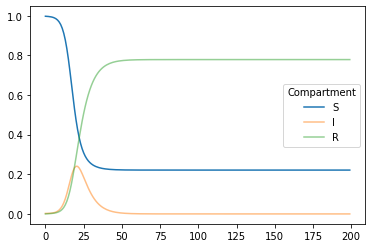

In [66]:
# plt.plot(pop_tap[:,0], alpha =0.5) # change of theta
# plt.plot(pop_tap[:,1])#change of p_infec 
# plt.plot(pop_tap[:,2]) change of p_suscep 
plt.plot(out[:,3], label = 'S') #proportion of S
# plt.plot(pop_tap[:,4], alpha = 0.5) change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'I') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'R')
plt.legend(title = 'Compartment')

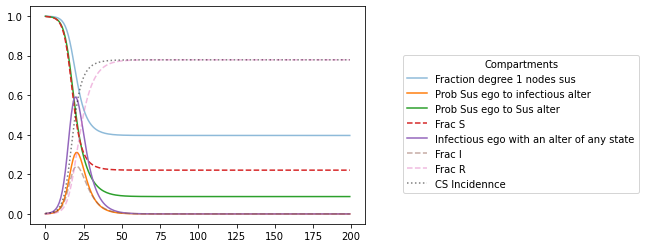

In [104]:
plt.plot(out[:,0], alpha =0.5, label = 'Fraction degree 1 nodes sus') # change of theta
plt.plot(out[:,1], label = 'Prob Sus ego to infectious alter',
        )#change of p_infec 
plt.plot(out[:,2], label = 'Prob Sus ego to Sus alter')# change of p_suscep 
plt.plot(out[:,3], label = 'Frac S', ls = '--') #proportion of S
plt.plot(out[:,4], label = 'Infectious ego with an alter of any state')# change of M_I 
plt.plot(out[:,5], alpha = 0.5, label = 'Frac I', ls = '--') # change of I
# recovered
plt.plot(1 - (out[:,5]+out[:,3]), alpha = 0.5, label= 'Frac R', ls = '--')
plt.plot(1 - (out[:,5]+out[:,3]) + out[:,5], alpha = 0.5, c = 'black',label= 'CS Incidennce', ls = ':')
plt.legend(title = 'Compartments', bbox_to_anchor = (1.1,0.8))
plt.show()